Aleksandra Tereszkiewicz

In this notebook I created a few CNNs to classify image datasets. Those datasets included MNIST and CIFAR-10. I also selected one dataset on my own - to classify animal photos.

In [ ]:
from __future__ import print_function
import numpy as np
import math
from math import ceil
import tensorflow as tf
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras.datasets import mnist
from keras import layers
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras import optimizers
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from keras.datasets import mnist
import tensorflow
from tensorflow.keras.utils import to_categorical
from keras import regularizers
import matplotlib.pyplot as plt
from keras.models import load_model
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/KCiDMB

Mounted at /content/drive
/content/drive/MyDrive/KCiDMB


In [ ]:
def PlotTwoAccuracyComparison(acc1, val_acc1, acc2, val_acc2, lab1 = 'Model 1', lab2 = 'Model 2'):
    #plt.clf()   # clear figure
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'
    plt.rcParams['figure.figsize'] = (15.0, 5.0)
    epochs = range(len(acc1))
    plt.plot(epochs, acc1, 'bo', label='Training accuracy for ' + lab1)
    plt.plot(epochs, val_acc1, 'b', label='Validation accuracy for ' + lab1)
    plt.plot(epochs, acc2, 'ro', label='Training accuracy for ' + lab2)
    plt.plot(epochs, val_acc2, 'r', label='Validation accuracy for ' + lab2)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train Acc 1', 'Val Acc 1', 'Train Acc 2', 'Val Acc 2'], loc='lower right')
    plt.show()

def PlotAccuracy(acc1, val_acc1, lab1 = 'Model 1'):
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'
    plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
    epochs = range(len(acc1))
    plt.plot(epochs, acc1, 'bo', label='Training accuracy for ' + lab1)
    plt.plot(epochs, val_acc1, 'b', label='Validation accuracy for ' + lab1)
    plt.title('Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train Acc', 'Val Acc'], loc='lower right')
    plt.show()

def PlotTwoLossComparison(loss1, val_loss1, loss2, val_loss2, lab1 = 'Model 1', lab2 = 'Model 2'):
    #plt.clf()   # clear figure
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'
    plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
    epochs = range(len(loss1))
    plt.plot(epochs, loss1, 'bo', label='Training loss for ' + lab1)
    plt.plot(epochs, val_loss1, 'b', label='Validation loss for ' + lab1)
    plt.plot(epochs, loss2, 'ro', label='Training loss for ' + lab2)
    plt.plot(epochs, val_loss2, 'r', label='Validation loss for ' + lab2)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train Loss 1', 'Val Loss 1', 'Train Loss 2', 'Val Loss 2'], loc='upper right')
    plt.show()


def PlotLoss(loss1, val_loss1, lab1 = 'Model 1'):
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'
    plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
    epochs = range(len(loss1))
    plt.plot(epochs, loss1, 'bo', label='Training loss for ' + lab1)
    plt.plot(epochs, val_loss1, 'b', label='Validation loss for ' + lab1)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train Loss', 'Val Loss '], loc='upper right')
    plt.show()

##MNIST dataset

In [ ]:
# The path to the directory where the dataset are stored
original_dataset_dir = 'D:\drugi stopien\KCiDMB\Laby\kaggle\original\train'

# Split the data between train and validation sets. Here we are using only two sets for model training and validation.
(x_train, y_train), (x_val, y_val) = mnist.load_data() # 60000 training and 10000 validating examples

# Number of training and val data
num_train_data = x_train.shape[0]
num_val_data = x_val.shape[0]

# Input image dimensions
img_rows, img_cols = x_train.shape[1], x_train.shape[2]

num_classes = np.size(np.unique(y_train))    # number of unique labels = number of classes of digits: 0, 1, 2, ..., 9
print ('Number of classes: ', num_classes)

## Distribution of the numbers training data of various classes
print ('Distribution of the numbers training data of various classes: ', np.unique(y_train, return_counts=True))

## Distribution of the numbers training data of various classes
print ('Distribution of the numbers validation data of various classes: ', np.unique(y_val, return_counts=True))

11490434/11490434 [==============================] - 0s 0us/step
Number of classes:  10
Distribution of the numbers training data of various classes:  (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
Distribution of the numbers validation data of various classes:  (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))


In [ ]:
# According to the different formats reshape training and validation data
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Transform training and validating data and show their shapes
x_train = x_train.astype('float32')   # Copy this array and cast it to a specified type
x_val = x_val.astype('float32')     # Copy this array and cast it to a specified type
x_train /= 255   # Transfrom the training data from the range of 0 and 255 to the range of 0 and 1
x_val /= 255    # Transfrom the validation data from the range of 0 and 255 to the range of 0 and 1

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')

# Convert class vectors (integers) to binary class matrices using as specific
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes) # y_train - a converted class vector into a matrix (integers from 0 to num_classes)
y_val = tensorflow.keras.utils.to_categorical(y_val, num_classes) # y_val - a converted class vector into a matrix (integers from 0 to num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 validation samples


###Model nr 1 - capacity

In [ ]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.20))
model2.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.30))
model2.add(Conv2D(128,(3, 3), activation='relu',padding='same')) #256
model2.add(Dropout(0.40))
model2.add(Conv2D(256,(3, 3), activation='relu',padding='same')) #512
model2.add(Dropout(0.50))
model2.add(Flatten())
model2.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
model2.add(Dropout(0.40))
model2.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.001))) #128
model2.add(Dropout(0.35))
model2.add(Dense(num_classes, activation='softmax'))

In [ ]:
epochs = 50
batch_size = 96

normalizer = tf.keras.layers.Normalization(input_shape=[128, 128, 1], axis=-1)
normalizer.adapt(x_train)

opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['acc'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
         factor=0.5,
         patience=5,
         verbose=1,
         min_lr=0.001)

datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.15,
        height_shift_range=0.15)

datagen.fit(x_train)

history2 = model2.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                            epochs=epochs,
                            steps_per_epoch=x_train.shape[0]//batch_size,
                            validation_data=(x_val, y_val),
                            verbose=1,
                            callbacks=[learning_rate_reduction])

Epoch 1/50
625/625 [==============================] - 240s 381ms/step - loss: 1.0677 - acc: 0.8850 - val_loss: 0.7013 - val_acc: 0.9762 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 237s 378ms/step - loss: 0.9108 - acc: 0.9143 - val_loss: 0.6468 - val_acc: 0.9805 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 235s 376ms/step - loss: 0.8384 - acc: 0.9272 - val_loss: 0.6088 - val_acc: 0.9853 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 234s 374ms/step - loss: 0.7813 - acc: 0.9375 - val_loss: 0.5749 - val_acc: 0.9861 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 235s 376ms/step - loss: 0.7535 - acc: 0.9410 - val_loss: 0.5350 - val_acc: 0.9876 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 238s 380ms/step - loss: 0.7108 - acc: 0.9457 - val_loss: 0.5274 - val_acc: 0.9878 - lr: 0.0010
Epoch 7/50
625/625 [==============================] - 237s 380ms/step - loss: 0.6886 - acc: 0.9500 - val_l

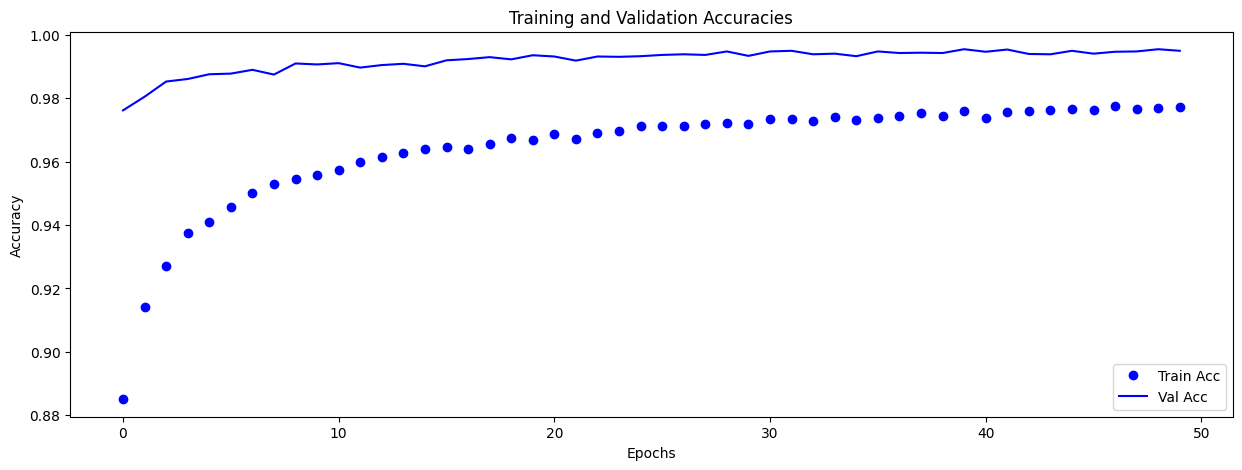

In [ ]:
acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']
PlotAccuracy(acc2, val_acc2, 'Model 2')

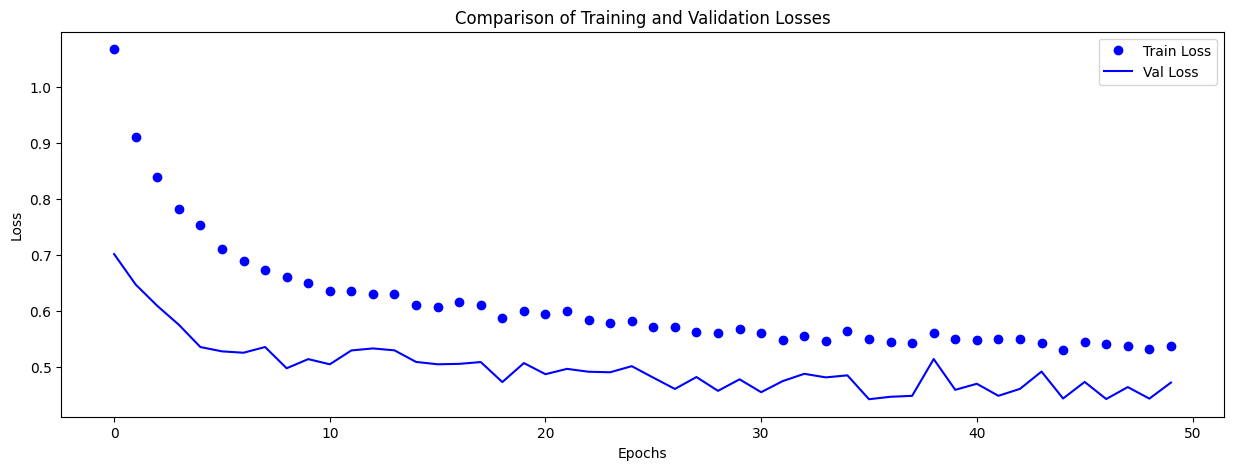

In [ ]:
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

PlotLoss(loss2, val_loss2, 'Model 2')

In [ ]:
argmax2 = np.argmax(val_acc2)
argmin2 = np.argmin(val_loss2)
print ('Max accuracy for model 2 is: ', val_acc2[argmax2], ', achieved in the ', argmax2 , 'epoch.')
print ('Min loss for model 2 is: ', val_loss2[argmin2], ', achieved in the ', argmin2 , 'epoch.')

Max accuracy for model 2 is:  0.9955000281333923 , achieved in the  39 epoch.
Min loss for model 2 is:  0.44173553586006165 , achieved in the  35 epoch.


In [ ]:
sum = np.sum(val_acc2)/50
sum2 = np.sum(val_loss2)/50

print('Validation accuracy:', sum)
print('Validation loss:', sum2)

Validation accuracy: 0.9920600020885467
Validation loss: 0.49754247307777405


In [ ]:
model2.save('./MNIST2.h5')
model2.save('./MNIST2.keras')

In [ ]:
LABELS= ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Define the confusion matrix for the results
def show_confusion_matrix(validations, predictions, num_classes):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(num_classes, num_classes))
    hm = sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)  # Don't rotate (vertically) the y-axis labels
    #hm.invert_yaxis() # Invert the labels of the y-axis
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
y_pred_val = model2.predict(x_val)

max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)

classcheck = max_y_val - max_y_pred_val  # 0 - when the class is the same, 1 - otherwise
misclassified = np.where(classcheck != 0)[0]
num_misclassified = len(misclassified)

# Print misclassification report
print('Number of misclassified examples: ', str(num_misclassified))
print('Misclassified examples:')
print(misclassified)

Number of misclassified examples:  8862
Misclassified examples:
[   0    1    3 ... 9997 9998 9999]


Here I tried changing model's capacity: I slightly reduced number of hidden layers, increased dropout rate and decreased batch size from 128 to 96.

Average accuracy for the model is 99.21% however loss function is at 49%. It is not a satisfactory result especially because it leaves almost 9 thousand wrongly classified images.

###Model nr 2 - optimization

In [ ]:
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.20))
model3.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))
model3.add(Conv2D(128,(3, 3), activation='relu',padding='same'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.30))
model3.add(Conv2D(128,(3, 3), activation='relu',padding='same'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.40))
#model3.add(Conv2D(256,(3, 3), activation='relu',padding='same'))
#model3.add(MaxPooling2D(pool_size=(2, 2)))
#model3.add(Dropout(0.50))
#model3.add(Conv2D(512,(3, 3), activation='relu',padding='same')) #additional convolutional layer
#model3.add(MaxPooling2D(pool_size=(2, 2)))
#model3.add(Dropout(0.50))
model3.add(Flatten())
model3.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
model3.add(Dropout(0.35))
model3.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
model3.add(Dropout(0.25))
model3.add(Dense(num_classes, activation='softmax'))

In [ ]:
epochs = 50
batch_size = 32

normalizer = tf.keras.layers.Normalization(input_shape=[128, 128, 1], axis=-1)
normalizer.adapt(x_train)

opt = keras.optimizers.SGD(
    learning_rate=0.01,
    momentum=0.0,
    nesterov=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    name="SGD")


model3.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['acc'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
         factor=0.5,
         patience=5,
         verbose=1,
         min_lr=0.001)

datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.15,
        height_shift_range=0.15)

datagen.fit(x_train)

history3 = model3.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                            epochs=epochs,
                            steps_per_epoch=x_train.shape[0]//batch_size,
                            validation_data=(x_val, y_val),
                            verbose=1,
                            callbacks=[learning_rate_reduction])

Epoch 1/50
1875/1875 [==============================] - 159s 84ms/step - loss: 3.6742 - acc: 0.2121 - val_loss: 2.8978 - val_acc: 0.4701 - lr: 0.0100
Epoch 2/50
1875/1875 [==============================] - 149s 79ms/step - loss: 2.6500 - acc: 0.4507 - val_loss: 1.6757 - val_acc: 0.7775 - lr: 0.0100
Epoch 3/50
1875/1875 [==============================] - 148s 79ms/step - loss: 1.8004 - acc: 0.6790 - val_loss: 0.9921 - val_acc: 0.9441 - lr: 0.0100
Epoch 4/50
1875/1875 [==============================] - 153s 82ms/step - loss: 1.2573 - acc: 0.8079 - val_loss: 0.6902 - val_acc: 0.9568 - lr: 0.0100
Epoch 5/50
1875/1875 [==============================] - 151s 80ms/step - loss: 0.9343 - acc: 0.8575 - val_loss: 0.4994 - val_acc: 0.9652 - lr: 0.0100
Epoch 6/50
1875/1875 [==============================] - 150s 80ms/step - loss: 0.7447 - acc: 0.8789 - val_loss: 0.3808 - val_acc: 0.9703 - lr: 0.0100
Epoch 7/50
1875/1875 [==============================] - 151s 81ms/step - loss: 0.6252 - acc: 0.8910 

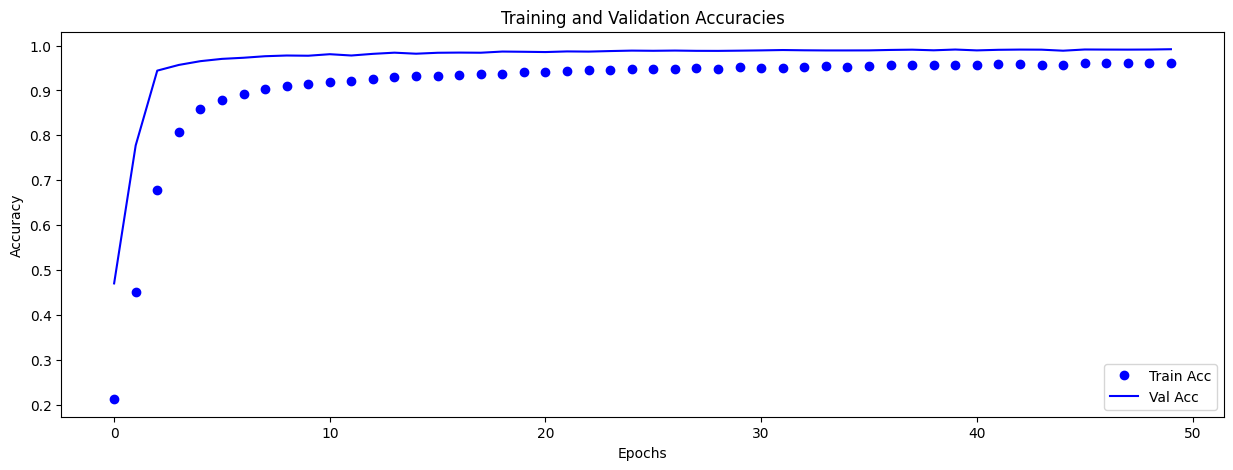

In [ ]:
acc3 = history3.history['acc']
val_acc3 = history3.history['val_acc']
PlotAccuracy(acc3, val_acc3, 'Model 3')

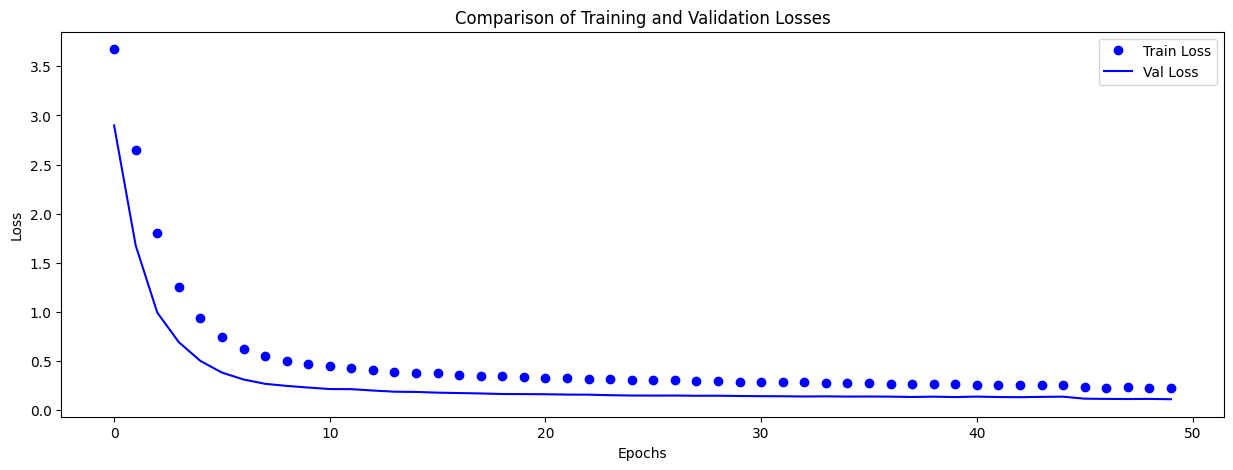

In [ ]:
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

PlotLoss(loss3, val_loss3, 'Model 3')

In [ ]:
argmax3 = np.argmax(val_acc3)
argmin3 = np.argmin(val_loss3)
print ('Max accuracy for model 3 is: ', val_acc3[argmax3], ', achieved in the ', argmax3 , 'epoch.')
print ('Min loss for model 3 is: ', val_loss3[argmin3], ', achieved in the ', argmin3 , 'epoch.')

Max accuracy for model 3 is:  0.9918000102043152 , achieved in the  49 epoch.
Min loss for model 3 is:  0.10942963510751724 , achieved in the  49 epoch.


In [ ]:
sum = np.sum(val_acc3)/50
sum2 = np.sum(val_loss3)/50

print('Validation accuracy:', sum)
print('Validation loss:', sum2)

Validation accuracy: 0.9699940013885499
Validation loss: 0.28214522808790204


In [ ]:
model3.save('./MNIST3.h5')
model3.save('./MNIST3.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In this model I decided to use different strategy - I changed optimization method from adaptive optimizers (such as Adam or Adadelta) to gradient descent optimizers. It means that the learning rate is modified manually .

Adam is an adaptive optimizer - it adjust learning rate during training. It learns quickly and isn't very sensitive to hyperparameters. Here I tried using a gradient descent optimizer, especially a mini-batch gradietn descent. It updates model parameters based on the average gradient computed over a subset of the training data (a mini-batch) in each iteration. It can generalize well because it introduces noise in gradient estimates.

The best accuracy (99.18%) and the lowest loss function (10.94%) are a really good result but they didn't really improve from the previous model.

##CIFAR-10

In [ ]:
from keras.datasets import cifar10 # gets CIFAR-10 dataset from repository

# Define hyperparameters
num_classes = 10 # number of classes of images

# Input image dimensions
img_rows, img_cols = 32, 32

# Split the data between train and val sets
(x_train, y_train), (x_val, y_val) = cifar10.load_data() # 50000 training and 10000 validating examples

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
# According to the different formats reshape training and validating data
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

# Transform training and validating data and show their shapes
x_train = x_train.astype('float32')   # Copy this array and cast it to a specified type
x_val = x_val.astype('float32')     # Copy this array and cast it to a specified type
x_train /= 255 # Transfrom the training data from the range of 0 and 255 to the range of 0 and 1
x_val /= 255  # Transfrom the validating data from the range of 0 and 255 to the range of 0 and 1
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validating samples')

# Convert class vectors to binary class matrices
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_val = tensorflow.keras.utils.to_categorical(y_val, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 validating samples


In [ ]:
model4 = Sequential()
model4.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=input_shape))
model4.add(Conv2D(64, (3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))
model4.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model4.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.35))
model4.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
model4.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.35))
model4.add(Flatten())
model4.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0005))) #512
model4.add(Dropout(0.5))
model4.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005))) #256
model4.add(Dropout(0.4))
model4.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))) #256
model4.add(Dropout(0.3))
model4.add(Dense(num_classes, activation='softmax'))

In [ ]:
print(model4.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                 

In [ ]:
batch_size = 256
epochs = 50

opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model4.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=opt,
               metrics=['acc'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', # quantity to be monitored (val_loss)
                                            factor=0.5, # factor by which the learning rate will be reduced. new_lr = lr * factor
                                            patience=5, # number of epochs that produced the monitored quantity with no improvement after which training will be stopped
                                            verbose=1,  # 0: quiet, 1: update messages.
                                            min_lr=0.0005) # lower bound on the learning rate

datagen = ImageDataGenerator(
          rotation_range=20,       # rotate images in degrees up to the given degrees
          width_shift_range=0.1,   # shift images horizontally
          height_shift_range=0.1,  # shift images vertically
          horizontal_flip=True)    # flip images (left<->right)

datagen.fit(x_train)

history4 = model4.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                            epochs=epochs,
                            steps_per_epoch=x_train.shape[0]//batch_size,  # no of mini-batches
                            validation_data=(x_val, y_val),
                            verbose=1,
                            callbacks=[learning_rate_reduction])

Epoch 1/50
195/195 [==============================] - 33s 143ms/step - loss: 2.2517 - acc: 0.2024 - val_loss: 1.7850 - val_acc: 0.3453 - lr: 0.0010
Epoch 2/50
195/195 [==============================] - 27s 141ms/step - loss: 1.7710 - acc: 0.3669 - val_loss: 1.4788 - val_acc: 0.4901 - lr: 0.0010
Epoch 3/50
195/195 [==============================] - 28s 142ms/step - loss: 1.5854 - acc: 0.4501 - val_loss: 1.3606 - val_acc: 0.5305 - lr: 0.0010
Epoch 4/50
195/195 [==============================] - 27s 141ms/step - loss: 1.4724 - acc: 0.5010 - val_loss: 1.2861 - val_acc: 0.5673 - lr: 0.0010
Epoch 5/50
195/195 [==============================] - 28s 144ms/step - loss: 1.3958 - acc: 0.5365 - val_loss: 1.1943 - val_acc: 0.6097 - lr: 0.0010
Epoch 6/50
195/195 [==============================] - 27s 139ms/step - loss: 1.3357 - acc: 0.5626 - val_loss: 1.0759 - val_acc: 0.6517 - lr: 0.0010
Epoch 7/50
195/195 [==============================] - 27s 140ms/step - loss: 1.2890 - acc: 0.5841 - val_loss: 1.

In [ ]:
batch_size = 256
epochs = 60

opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model4.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=opt,
               metrics=['acc'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', # quantity to be monitored (val_loss)
                                            factor=0.2, # factor by which the learning rate will be reduced. new_lr = lr * factor
                                            patience=5, # number of epochs that produced the monitored quantity with no improvement after which training will be stopped
                                            verbose=1,  # 0: quiet, 1: update messages.
                                            min_lr=0.001) # lower bound on the learning rate

datagen = ImageDataGenerator(
          rotation_range=20,       # rotate images in degrees up to the given degrees
          width_shift_range=0.1,   # shift images horizontally
          height_shift_range=0.1,  # shift images vertically
          horizontal_flip=True)    # flip images (left<->right)

datagen.fit(x_train)

history4 = model4.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                            epochs=epochs,
                            steps_per_epoch=x_train.shape[0]//batch_size,  # no of mini-batches
                            validation_data=(x_val, y_val),
                            verbose=1,
                            callbacks=[learning_rate_reduction])

Epoch 1/60
195/195 [==============================] - 43s 203ms/step - loss: 0.7503 - acc: 0.7820 - val_loss: 0.6369 - val_acc: 0.8176 - lr: 0.0010
Epoch 2/60
195/195 [==============================] - 38s 197ms/step - loss: 0.7464 - acc: 0.7849 - val_loss: 0.7410 - val_acc: 0.7889 - lr: 0.0010
Epoch 3/60
195/195 [==============================] - 34s 174ms/step - loss: 0.7466 - acc: 0.7832 - val_loss: 0.7190 - val_acc: 0.7979 - lr: 0.0010
Epoch 4/60
195/195 [==============================] - 29s 149ms/step - loss: 0.7342 - acc: 0.7876 - val_loss: 0.6226 - val_acc: 0.8229 - lr: 0.0010
Epoch 5/60
195/195 [==============================] - 30s 153ms/step - loss: 0.7388 - acc: 0.7873 - val_loss: 0.6669 - val_acc: 0.8064 - lr: 0.0010
Epoch 6/60
195/195 [==============================] - 30s 151ms/step - loss: 0.7307 - acc: 0.7878 - val_loss: 0.6723 - val_acc: 0.8051 - lr: 0.0010
Epoch 7/60
195/195 [==============================] - 29s 147ms/step - loss: 0.7287 - acc: 0.7899 - val_loss: 0.

In [ ]:
model4.save('./CIFAR1.h5')
model4.save('./CIFAR1.keras')

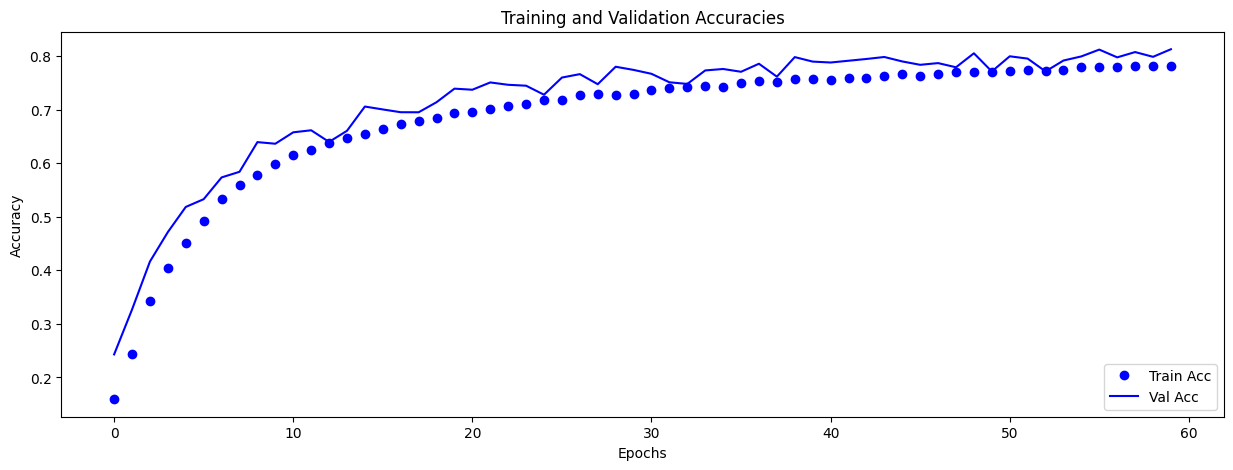

In [ ]:
acc4 = history4.history['acc']
val_acc4 = history4.history['val_acc']
PlotAccuracy(acc4, val_acc4, 'Model 4')

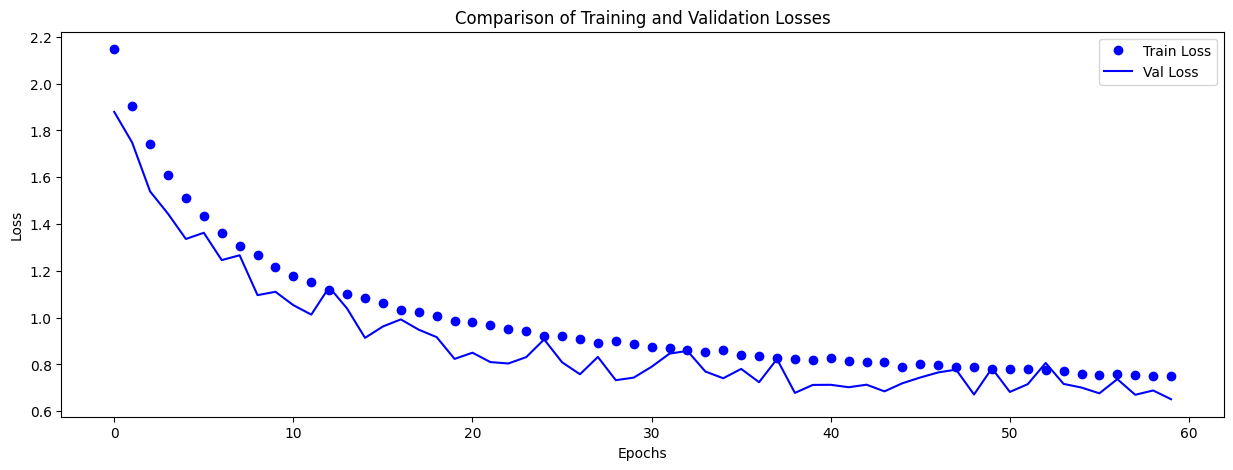

In [ ]:
loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']

PlotLoss(loss4, val_loss4, 'Model 4')

In [ ]:
argmax4 = np.argmax(val_acc4)
argmin4 = np.argmin(val_loss4)
print ('Max accuracy for model 4 is: ', val_acc4[argmax4], ', achieved in the ', argmax4 , 'epoch.')
print ('Min loss for model 4 is: ', val_loss4[argmin4], ', achieved in the ', argmin4 , 'epoch.')

Max accuracy for model 4 is:  0.8126000165939331 , achieved in the  59 epoch.
Min loss for model 4 is:  0.6512856483459473 , achieved in the  59 epoch.


In [ ]:
sum = np.sum(val_acc4)/60
sum2 = np.sum(val_loss4)/60

print('Validation accuracy:', sum)
print('Validation loss:', sum2)

Validation accuracy: 0.7154999993741512
Validation loss: 0.899047726392746


In [ ]:
y_pred_val = model4.predict(x_val)

# Take the class with the highest probability from the val predictions as a winning one
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)

classcheck = max_y_val - max_y_pred_val  # 0 - when the class is the same, 1 - otherwise
misclassified = np.where(classcheck != 0)[0]
num_misclassified = len(misclassified)
print('There are ', num_misclassified, ' missclassified images.')

There are  1874  images.


In [ ]:
score_train = model4.evaluate(x_train, y_train, verbose=0)
print('Train loss:', score_train[0])
print('Train accuracy:', score_train[1])
print('Bias:', score_train[1])

score_val = model4.evaluate(x_val, y_val, verbose=0)
print('Validation loss:', score_val[0])
print('Validation accuracy:', score_val[1])
print('Variance:', score_val[1] - score_train[1])

Train loss: 0.5316298007965088
Train accuracy: 0.844539999961853
Bias: 0.844539999961853
Validation loss: 0.6512856483459473
Validation accuracy: 0.8126000165939331
Variance: -0.03193998336791992


Bias is model's inability to classify data correctly because of its wrong assumptions about data. It causes underfitting - model does not match data well enough.

One way to reduce high bias is to make the model more complex, for example increase number of layers. This is why I trained model with 6 convolutional layers.

Another way to reduce high bias is to reduce regularization. It is designed to prevent overfitting because it causes generalization - but in case of high bias generalization is not ideal. This is why I reduced L1 regularizer weight from 0.001 to 0.0005 in dense layers.

I also changed learning rate factor to 0.2. It is the amount of weights that are updated during training. Smaller factor slows training down but allows the model to learn more optimal set of weights. Another thing I changed is batch size - I decreased it halfway (to 256). Also I made the learning process longer by having 60 epochs instead of 50.

Validation accuracy of 83.88% is satisfactory. However validation loss is still very high. In original notebook loss function was about 75%, so I achieved a better model but after so much training it still is quite high.

##My dataset

In [ ]:
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.tree import *
from sklearn.ensemble import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import *
from tensorflow.keras.applications import *

In [10]:
from sklearn.model_selection import train_test_split
import os

# Ścieżki do folderów z obrazami
alpaca_dir = "/content/drive/MyDrive/KCiDMB/alpacas/alpaca"
not_alpaca_dir = "/content/drive/MyDrive/KCiDMB/alpacas/not alpaca"

# Wczytanie ścieżek do obrazów z każdej klasy
alpaca_images = [os.path.join(alpaca_dir, img) for img in os.listdir(alpaca_dir)]
not_alpaca_images = [os.path.join(not_alpaca_dir, img) for img in os.listdir(not_alpaca_dir)]

# Tworzenie listy z etykietami dla obrazów
alpaca_labels = [1] * len(alpaca_images)  # Etykieta 1 dla alpaki
not_alpaca_labels = [0] * len(not_alpaca_images)  # Etykieta 0 dla obrazów innych niż alpaka

# Połączenie obrazów i etykiet w jedną listę
all_images = alpaca_images + not_alpaca_images
all_labels = alpaca_labels + not_alpaca_labels

# Podział danych na zbiory treningowy i walidacyjny
train_images, val_images, train_labels, val_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

# Sprawdzenie, czy dane zostały podzielone poprawnie
print("Liczba obrazów treningowych:", len(train_images))
print("Liczba obrazów walidacyjnych:", len(val_images))

Liczba obrazów treningowych: 261
Liczba obrazów walidacyjnych: 66


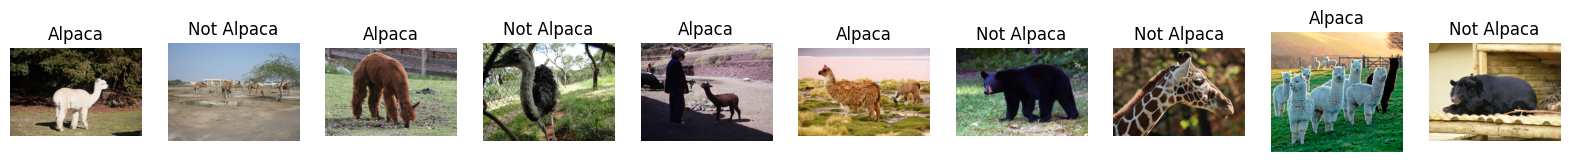

In [11]:
import matplotlib.image as mpimg

plt.figure(figsize=(20, 20))
for i in range(10):
    img = mpimg.imread(train_images[i+22])
    plt.subplot(1, 10, i + 1)
    plt.imshow(img)
    plt.title('Alpaca' if train_labels[i+22] == 1 else 'Not Alpaca')
    plt.axis('off')
plt.show()

In [14]:
train_data_dir = "/content/drive/MyDrive/KCiDMB/alpacas"
image_size = (224,224)

dataset = image_dataset_from_directory(
    train_data_dir,
    image_size=image_size,
)

Found 327 files belonging to 2 classes.


In [15]:
train = image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    seed=1,
    subset ="training",
    label_mode="int",
    image_size=image_size
)

validation_dataset = image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    seed=1,
    subset ="validation",
    label_mode="int",
    image_size=image_size
)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


In [20]:
model = Sequential()
model.add(InputLayer(input_shape=(224,224,3)))
model.add(Conv2D(128, (3,3), activation='tanh'))
model.add(Conv2D(128, (3,3), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Conv2D(64, (3,3), activation='tanh'))
model.add(Conv2D(32, (3,3), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(16, (3,3), activation='tanh'))
model.add(Conv2D(16, (3,3), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(4, (3,3), activation='tanh'))
model.add(Conv2D(4, (3,3), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 128)     3584      
                                                                 
 conv2d_9 (Conv2D)           (None, 220, 220, 128)     147584    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 110, 110, 128)     0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 110, 110, 128)     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 108, 108, 64)      73792     
                                                                 
 conv2d_11 (Conv2D)          (None, 106, 106, 32)      18464     
                                                      

In [22]:
opt = tensorflow.keras.optimizers.SGD(learning_rate=0.001)

model.compile(loss='sparse_categorical_crossentropy',
               optimizer=opt,
               metrics=['acc'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', # quantity to be monitored (val_loss)
                                            factor=0.5, # factor by which the learning rate will be reduced. new_lr = lr * factor
                                            patience=5, # number of epochs that produced the monitored quantity with no improvement after which training will be stopped
                                            verbose=1,  # 0: quiet, 1: update messages.
                                            min_lr=0.001)

history = model.fit(#datagen.flow(train, batch_size=16),
                    (train),
                    validation_data=(validation_dataset),
                    epochs = 50,
                    batch_size = 8,
                    verbose = 1,
                    callbacks=[learning_rate_reduction])

Epoch 1/50
9/9 [==============================] - 30s 1s/step - loss: 0.7004 - acc: 0.4847 - val_loss: 0.6937 - val_acc: 0.5077 - lr: 0.0010
Epoch 2/50
9/9 [==============================] - 7s 600ms/step - loss: 0.6973 - acc: 0.5229 - val_loss: 0.6937 - val_acc: 0.5077 - lr: 0.0010
Epoch 3/50
9/9 [==============================] - 7s 602ms/step - loss: 0.6852 - acc: 0.5840 - val_loss: 0.6936 - val_acc: 0.5231 - lr: 0.0010
Epoch 4/50
9/9 [==============================] - 7s 598ms/step - loss: 0.6943 - acc: 0.5534 - val_loss: 0.6935 - val_acc: 0.4923 - lr: 0.0010
Epoch 5/50
9/9 [==============================] - 8s 600ms/step - loss: 0.7035 - acc: 0.5153 - val_loss: 0.6933 - val_acc: 0.4923 - lr: 0.0010
Epoch 6/50
9/9 [==============================] - 8s 667ms/step - loss: 0.6922 - acc: 0.5344 - val_loss: 0.6932 - val_acc: 0.4462 - lr: 0.0010
Epoch 7/50
9/9 [==============================] - 7s 598ms/step - loss: 0.7023 - acc: 0.4733 - val_loss: 0.6930 - val_acc: 0.4615 - lr: 0.0010
E

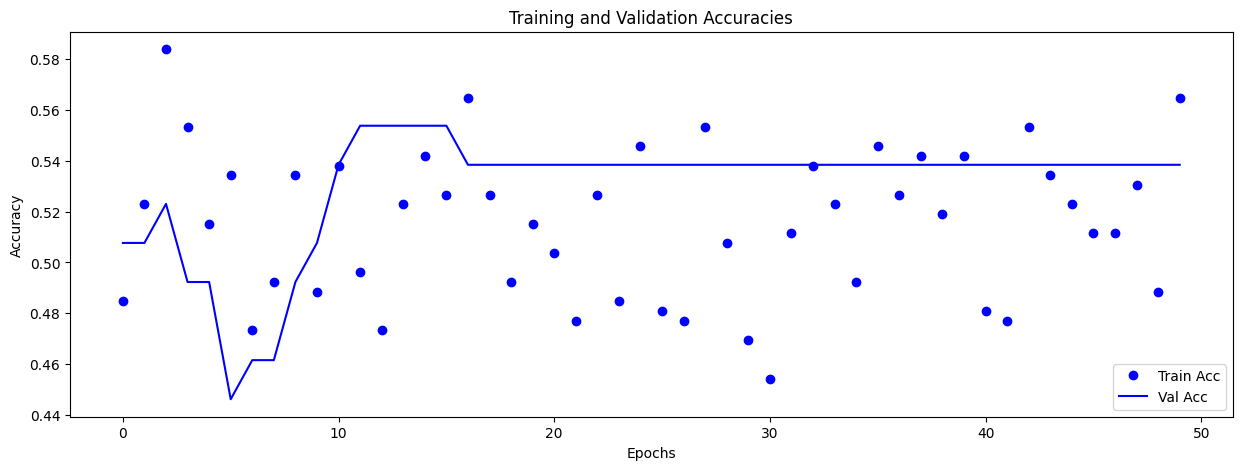

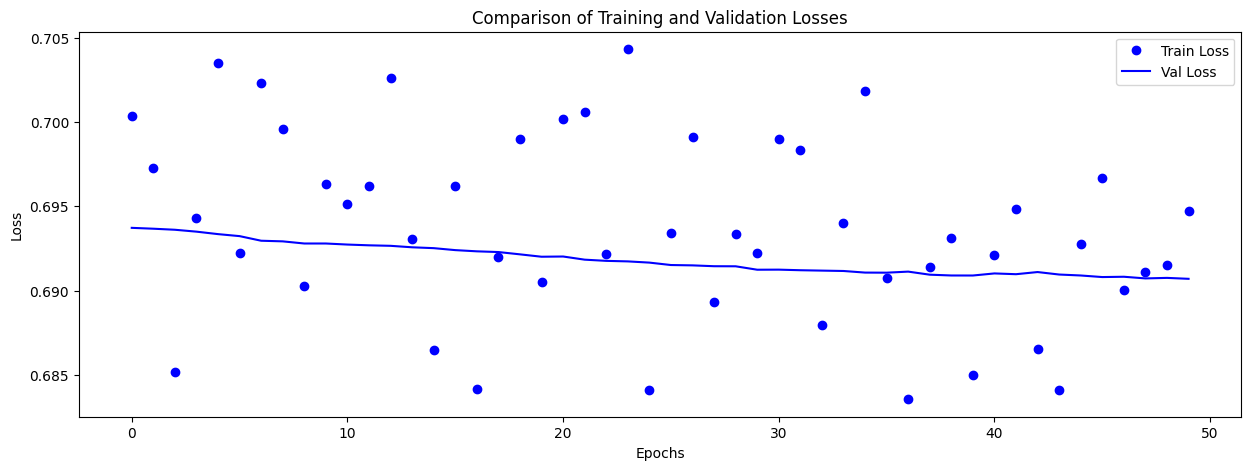

Max accuracy for model is:  0.5538461804389954 , achieved in the  11 epoch.
Min loss for model is:  0.6906967163085938 , achieved in the  49 epoch.
Validation accuracy: 0.44179489215215045
Validation loss: 0.5765413840611776


In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
PlotAccuracy(acc, val_acc, 'Model')
loss = history.history['loss']
val_loss = history.history['val_loss']

PlotLoss(loss, val_loss, 'Model')

argmax = np.argmax(val_acc)
argmin = np.argmin(val_loss)
print ('Max accuracy for model is: ', val_acc[argmax], ', achieved in the ', argmax , 'epoch.')
print ('Min loss for model is: ', val_loss[argmin], ', achieved in the ', argmin , 'epoch.')
sum = np.sum(val_acc)/60
sum2 = np.sum(val_loss)/60

print('Validation accuracy:', sum)
print('Validation loss:', sum2)

In [24]:
model = Sequential()
model.add(InputLayer(input_shape=(224,224,3)))
model.add(Conv2D(256, (3,3), activation='tanh'))
model.add(Conv2D(256, (3,3), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Conv2D(128, (3,3), activation='tanh'))
model.add(Conv2D(128, (3,3), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3,3), activation='tanh'))
model.add(Conv2D(32, (3,3), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(16, (3,3), activation='tanh'))
model.add(Conv2D(8, (3,3), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [28]:
opt = tensorflow.keras.optimizers.SGD(learning_rate=0.001)

model.compile(loss='sparse_categorical_crossentropy',
               optimizer=opt,
               metrics=['acc'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', # quantity to be monitored (val_loss)
                                            factor=0.2, # factor by which the learning rate will be reduced. new_lr = lr * factor
                                            patience=3, # number of epochs that produced the monitored quantity with no improvement after which training will be stopped
                                            verbose=1,  # 0: quiet, 1: update messages.
                                            min_lr=0.0005)

history = model.fit(#datagen.flow(train, batch_size=16),
                    (train),
                    validation_data=(validation_dataset),
                    epochs = 15,
                    batch_size = 8,
                    verbose = 1,
                    callbacks=[learning_rate_reduction])

Epoch 1/15
9/9 [==============================] - 73s 2s/step - loss: 0.7566 - acc: 0.4771 - val_loss: 0.7070 - val_acc: 0.5385 - lr: 0.0010
Epoch 2/15
9/9 [==============================] - 19s 2s/step - loss: 0.7175 - acc: 0.5305 - val_loss: 0.7058 - val_acc: 0.5385 - lr: 0.0010
Epoch 3/15
9/9 [==============================] - 18s 2s/step - loss: 0.7190 - acc: 0.5267 - val_loss: 0.7047 - val_acc: 0.5385 - lr: 0.0010
Epoch 4/15
9/9 [==============================] - ETA: 0s - loss: 0.6988 - acc: 0.5344
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005.
9/9 [==============================] - 21s 2s/step - loss: 0.6988 - acc: 0.5344 - val_loss: 0.7034 - val_acc: 0.5385 - lr: 0.0010
Epoch 5/15
9/9 [==============================] - 19s 2s/step - loss: 0.6995 - acc: 0.5534 - val_loss: 0.7034 - val_acc: 0.5385 - lr: 5.0000e-04
Epoch 6/15
9/9 [==============================] - 21s 2s/step - loss: 0.7144 - acc: 0.5229 - val_loss: 0.7028 - val_acc: 0.5385 - lr: 5.0000e-04
Epoch 7/1

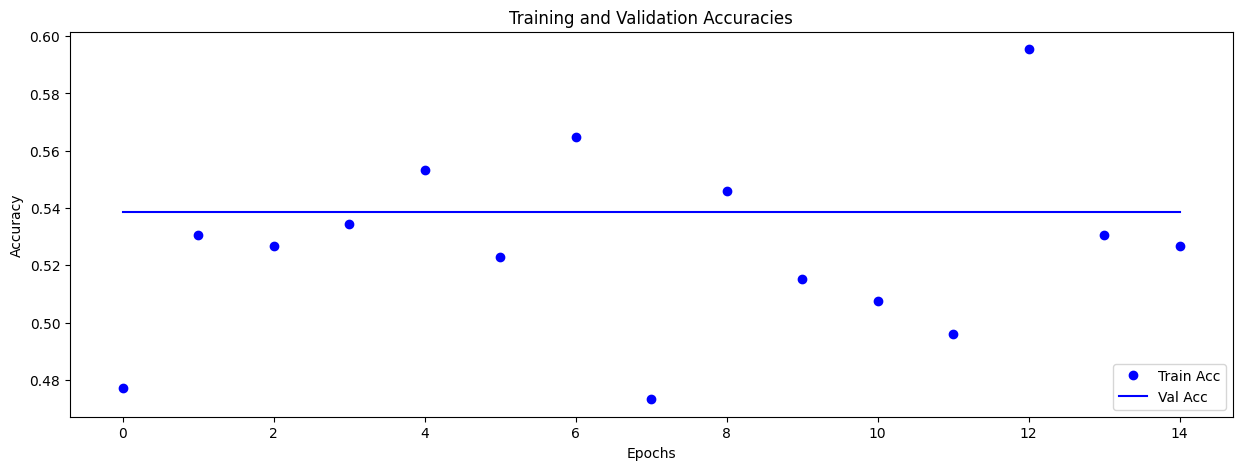

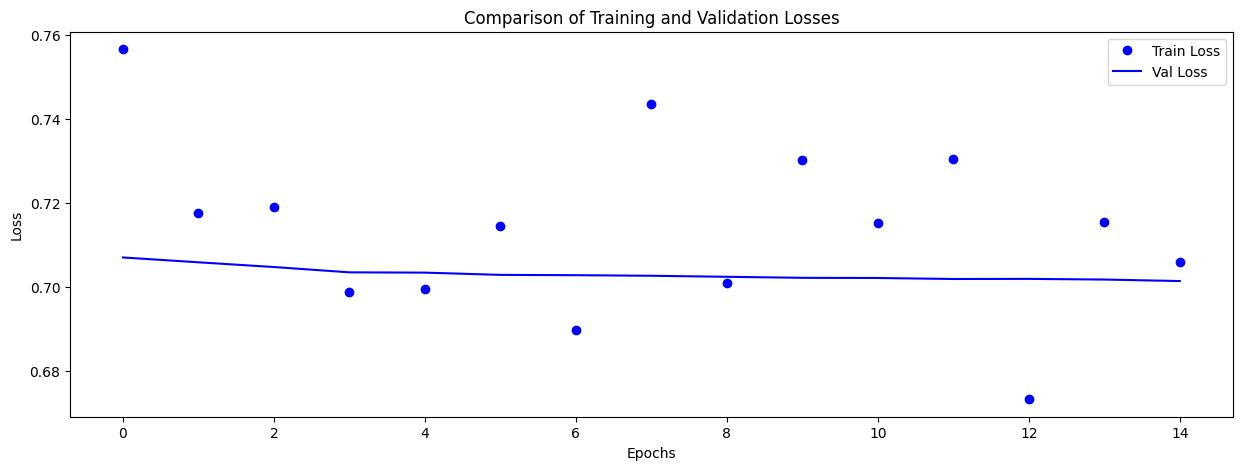

Max accuracy for model is:  0.5384615659713745 , achieved in the  0 epoch.
Min loss for model is:  0.701367974281311 , achieved in the  14 epoch.
Validation accuracy: 0.13461539149284363
Validation loss: 0.17576732039451598


In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
PlotAccuracy(acc, val_acc, 'Model')
loss = history.history['loss']
val_loss = history.history['val_loss']

PlotLoss(loss, val_loss, 'Model')

argmax = np.argmax(val_acc)
argmin = np.argmin(val_loss)
print ('Max accuracy for model is: ', val_acc[argmax], ', achieved in the ', argmax , 'epoch.')
print ('Min loss for model is: ', val_loss[argmin], ', achieved in the ', argmin , 'epoch.')
sum = np.sum(val_acc)/60
sum2 = np.sum(val_loss)/60

print('Validation accuracy:', sum)
print('Validation loss:', sum2)

This was a challenging model to create and train mainly because of the dataset. I tried using many other datasets but I had problems either with Google drive or RAM memory. This is why I decided to stuck with a very small dataset - only a couple hundred images.

I tried using different number of layers, added a lot of dropout, had multiple convolutional layers with many filters, tried different activation functions, and also tried different options of learning rate parametrs. I decided on a small batch of only 8, because of the small size of the dataset. Unfortunately no matter what parameter I changed, there seemed to be little change in accuracy. Usually it stopped at 53.85% (once I managed to get 56%) and it basically means randomness in classification.

The only other thing I could think of doing was data augmentation (rotating and flipping images) but I had trouble with image data types in this dataset and ImageDataGenerator function didn't want to compile.


##Summary

To sum up, this was a challenging notebook for me. Tackling new datasets was troublesome for me. Nevertheless I feel that I learned a lot: I learnt what is a callback, what is a pooling layer, learning rate, bias and variance. I also learned how to optimize models to perform better.

